In [1]:
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import seaborn as sns
%matplotlib inline

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import classification_report

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import pickle



In [3]:
pd.set_option('display.max_columns', None)

In [4]:
d = pd.read_csv("../data/data.csv")

In [38]:
def save_model_to_disk(model, gzip=True):
    import gzip
    if gzip:
        with gzip.open('model.pkl.gzip','wb') as f:
            pickle.dump(model, f) 
    else:
        with open('model.pkl', 'wb') as f:
            pickle.dump(model, f)

In [26]:
def plot_roc(y_hat, y, notes=None):
    
    fpr, tpr, thresholds = roc_curve(y, y_hat[:,1], pos_label=1)
    roc_auc = roc_auc_score(y, y_hat[:,1])
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label=f'ROC curve (area = {roc_auc:2})')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC' + '\n' + notes)
    plt.legend(loc="lower right")
    plt.show()
    return roc_auc

In [5]:
categorical_columns = ['gender',
                       'ecg',
                       'chestpain',
                       'restwma',
                       'posSE',
                       'newMI',
                       'newPTCA',
                       'newCABG',
                       'death',
                       'hxofCig',
                       'hxofHT',
                      'hxofDM',
                      'hxofMI',
                      'hxofPTCA',
                      'hxofCABG',
                       'any.event',
                      ]
numeric_columns = ['sbp',
                 'baseEF',
                 'dpmaxdo',
                 'mbp',
                 'basebp',
                 'basedp',
                 'pctMphr',
                 'dobdose',
                 'dp',
                 'maxhr',
                 'pkhr',
                 'age',
                 'bhr',
                  ]

targets = ['any.event',
           'death',
           'newMI',
           'newPTCA',
           'newCABG']

In [6]:
def coerce_heartrate(df) -> pd.DataFrame:
    """
    Negative heartrates get coerced to 60
    """
    bhr = df['bhr'].apply(lambda x: x if x > 0 else 60)
    df = df.copy()
    df['bhr'] = bhr
    return df

In [7]:
def coerce_age(df:pd.DataFrame) -> pd.DataFrame:
    """
    Ages above 100 get coerced to 100
    """
    age = df['age'].apply(lambda x: x if x < 100 else 100)
    df = df.copy()
    df['age'] = age
    return df

In [59]:
def compute_dp(df:pd.DataFrame) -> pd.DataFrame:
    dp = df['pkhr'] * df['basebp']
    df = df.copy()
    df['dp'] = dp
    return df

In [60]:
def compute_basedp(df:pd.DataFrame) -> pd.DataFrame:
    basedp = df['bhr'] * df['basebp']
    df = df.copy()
    df['basedp'] = basedp
    return df

In [61]:
clean_data = pd.get_dummies(                           
    d.set_index(['PatientIdentifier']) 
    .fillna(d[categorical_columns].mode().iloc[0]) 
    .fillna(d[numeric_columns].mean()) 
    .pipe(coerce_heartrate)
    .pipe(coerce_age)
    .pipe(compute_dp)
    .pipe(compute_basedp)
)

In [62]:
clean_data.describe()

,bhr,basebp,basedp,pkhr,sbp,dp,maxhr,pctMphr,mbp,dpmaxdo,dobdose,age,baseEF,chestpain,restwma,posSE,newMI,newPTCA,newCABG,death,hxofHT,hxofDM,hxofMI,hxofPTCA,hxofCABG,any.event,gender_female,gender_male,hxofCig_heavy,hxofCig_moderate,hxofCig_non-smoker,ecg_MI,ecg_equivocal,ecg_normal
count,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000,558.000000
mean,75.130895,135.293165,10158.080400,120.643243,147.035185,16262.102000,119.306422,78.561798,155.615527,18547.702899,30.237226,67.989001,55.511111,0.299283,0.453405,0.236559,0.050179,0.048387,0.059140,0.039427,0.715054,0.369176,0.274194,0.073477,0.157706,0.159498,0.605735,0.394265,0.218638,0.247312,0.534050,0.127240,0.315412,0.557348
std,15.413446,20.762192,2581.509971,22.523132,36.085236,3686.862644,21.756273,14.895535,31.211850,4885.634142,9.457375,12.568604,10.251149,0.458355,0.498271,0.425351,0.218510,0.214775,0.236098,0.194782,0.451794,0.483015,0.446507,0.261151,0.364792,0.366469,0.489131,0.489131,0.413693,0.431837,0.499287,0.333541,0.465097,0.497146
min,42.000000,85.000000,5000.000000,52.000000,40.000000,6840.000000,58.000000,38.000000,84.000000,7130.000000,5.000000,26.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,64.000000,120.000000,8400.000000,107.000000,122.000000,13592.500000,105.000000,70.000000,134.000000,15261.000000,25.000000,61.000000,52.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,73.000000,133.000000,9727.000000,122.000000,143.000000,16339.000000,120.000000,78.561798,151.000000,18202.000000,30.000000,68.917440,57.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,84.000000,150.000000,11623.750000,135.000000,170.000000,18663.750000,133.000000,88.000000,174.000000,21197.500000,40.000000,76.000000,62.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,210.000000,203.000000,27300.000000,210.000000,309.000000,28305.000000,200.000000,133.000000,309.000000,45114.000000,40.000000,100.000000,83.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [63]:
clean_data.shape

(558, 34)

In [64]:
clean_data['any.event'].value_counts()

0.0    469
1.0     89
Name: any.event, dtype: int64

In [65]:
feature_columns = list(set(clean_data.columns) - set(targets))

In [66]:
print(f"Feature column names: {feature_columns}")

Feature column names: ['chestpain', 'hxofCABG', 'mbp', 'hxofMI', 'gender_male', 'hxofCig_non-smoker', 'hxofPTCA', 'age', 'dp', 'pctMphr', 'hxofCig_heavy', 'restwma', 'ecg_equivocal', 'hxofDM', 'ecg_normal', 'dobdose', 'hxofCig_moderate', 'dpmaxdo', 'basebp', 'maxhr', 'sbp', 'baseEF', 'pkhr', 'hxofHT', 'ecg_MI', 'basedp', 'posSE', 'bhr', 'gender_female']


In [67]:
def get_split_data(df:pd.DataFrame, feature_columns:list, target_column:str) -> tuple:
    """
    
    """
    
    X_train, X_test, y_train, y_test = train_test_split(df[feature_columns],
                                                    df[target_column],
                                                    stratify=df[target_column],
                                                    test_size=0.25,
                                                    random_state=134)
    
    return X_train, X_test, y_train, y_test

In [68]:
X_train, X_test, y_train, y_test = get_split_data(clean_data, feature_columns, 'any.event')

In [69]:
# Assert that test and train have the same ratio of death events
assert round(y_test.mean(),2) == round(y_train.mean(),2)

In [70]:
print(f"Data shape: {X_train.shape}")

Data shape: (418, 29)


In [71]:
assert X_train.shape[1] == X_test.shape[1]
assert (X_train.shape[0] + X_test.shape[0]) == d.shape[0]

In [72]:
assert round(d['any.event'].mean(),2) == round(y_train.mean(),2)
assert round(d['any.event'].mean(),2) == round(y_test.mean(),2)

## Pipeline 1 - Logistic Reg. (Chi2-test dim. reduction)

In [73]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

In [74]:
ss = StandardScaler()    
lr = LogisticRegression(class_weight='balanced',
                        solver='liblinear',)

pipe = Pipeline([
    ('reduce_dim', SelectKBest(chi2)),
    ('scaler', ss),
    ('logistic', lr)
])

In [75]:
param_grid = {
        'reduce_dim': [SelectKBest(chi2)],
        'reduce_dim__k': sp_randint(4,29),
        'logistic__C': uniform(loc=0, scale=4),
        'logistic__penalty': ['l1','l2']
}
    

grid_search = RandomizedSearchCV(pipe,
                                 scoring='recall',
                                 param_distributions=param_grid,
                                 n_iter=1000,
                                 cv=5,
                                 verbose=0,
                                 n_jobs=-1)

grid_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('reduce_dim', SelectKBest(k=10, score_func=<function chi2 at 0x1a18b4f8c8>)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logistic', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))]),
          fit_params=None, iid=True, n_iter=1000, n_jobs=-1,
          param_distributions={'reduce_dim': [SelectKBest(k=14, score_func=<function chi2 at 0x1a18b4f8c8>)], 'reduce_dim__k': <scipy.stats._distn_infrastructure.rv_frozen object at 0x105df3320>, 'logistic__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x105df35c0>, 'logistic__penalty': ['l1', 'l2']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_tra

In [76]:
grid_search.best_params_

{'logistic__C': 0.006343016890581588,
 'logistic__penalty': 'l2',
 'reduce_dim': SelectKBest(k=14, score_func=<function chi2 at 0x1a18b4f8c8>),
 'reduce_dim__k': 14}

In [77]:
print(classification_report(y_test, grid_search.predict(X_test)))

             precision    recall  f1-score   support

        0.0       0.95      0.69      0.80       118
        1.0       0.33      0.82      0.47        22

avg / total       0.86      0.71      0.75       140



In [78]:
print(classification_report(y_train, grid_search.predict(X_train)))

             precision    recall  f1-score   support

        0.0       0.95      0.65      0.77       351
        1.0       0.31      0.81      0.44        67

avg / total       0.84      0.68      0.72       418



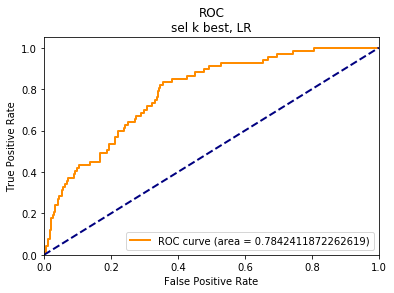

0.7842411872262619

In [98]:
plot_roc(grid_search.predict_proba(X_train), y_train, notes=f"sel k best, LR")

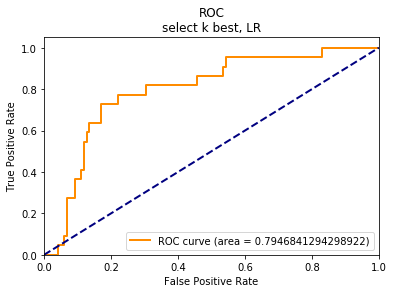

0.7946841294298922

In [80]:
plot_roc(grid_search.predict_proba(X_test), y_test, notes=f'select k best, LR')

# Pipeline 2 - Logistic Reg. (PCA dim. red)

In [81]:
param_grid = {
        'reduce_dim': [PCA()],
        'reduce_dim__whiten': [True, False],
        'reduce_dim__n_components': sp_randint(4,29),
        'logistic__C': uniform(loc=0, scale=4),
        'logistic__penalty': ['l1','l2']
}
    

grid_search2 = RandomizedSearchCV(pipe,
                                 scoring='recall',
                                 param_distributions=param_grid,
                                 n_iter=1000,
                                 cv=5,
                                 verbose=0,
                                 n_jobs=-1)

grid_search2.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('reduce_dim', SelectKBest(k=10, score_func=<function chi2 at 0x1a18b4f8c8>)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logistic', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))]),
          fit_params=None, iid=True, n_iter=1000, n_jobs=-1,
          param_distributions={'reduce_dim': [PCA(copy=True, iterated_power='auto', n_components=18, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)], 'reduce_dim__whiten': [True, False], 'reduce_dim__n_components': <scipy.stats._distn_infrastructure.rv_frozen object at 0x105def240>, 'logistic__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1a2caa20>, 'logistic__penalty

{'logistic__C': 0.04887446137603835, 'logistic__penalty': 'l1', 'reduce_dim': PCA(copy=True, iterated_power='auto', n_components=18, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True), 'reduce_dim__n_components': 18, 'reduce_dim__whiten': True}
             precision    recall  f1-score   support

        0.0       0.91      0.64      0.75       118
        1.0       0.26      0.68      0.38        22

avg / total       0.81      0.64      0.69       140



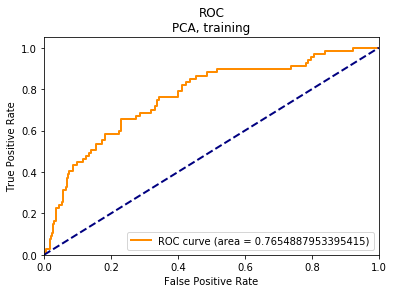

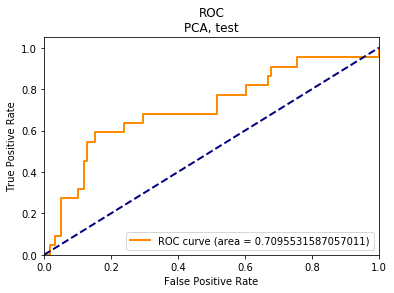

0.7095531587057011

In [83]:
print(grid_search2.best_params_)
print(classification_report(y_test, grid_search2.predict(X_test)))
plot_roc(grid_search2.predict_proba(X_train), y_train, notes="PCA, training")
plot_roc(grid_search2.predict_proba(X_test), y_test, notes="PCA, test")


In [101]:
save_model_to_disk(grid_search,gzip=True)

In [102]:
X_train.iloc[0]

chestpain                 0.0
hxofCABG                  0.0
mbp                     148.0
hxofMI                    0.0
gender_male               0.0
hxofCig_non-smoker        1.0
hxofPTCA                  0.0
age                      60.0
dp                    15912.0
pctMphr                  73.0
hxofCig_heavy             0.0
restwma                   1.0
ecg_equivocal             0.0
hxofDM                    0.0
ecg_normal                1.0
dobdose                  20.0
hxofCig_moderate          0.0
dpmaxdo               17316.0
basebp                  136.0
maxhr                   117.0
sbp                     148.0
baseEF                   64.0
pkhr                    117.0
hxofHT                    0.0
ecg_MI                    0.0
basedp                 9792.0
posSE                     0.0
bhr                      72.0
gender_female             1.0
Name: 3be52991480e840e3aa84c9c0341cc6d, dtype: float64

In [105]:
ex1 = list(X_train.iloc[0])
print(f"{ex1}")
print(f"{y_train.iloc[0]}")

[0.0, 0.0, 148.0, 0.0, 0.0, 1.0, 0.0, 60.0, 15912.0, 73.0, 0.0, 1.0, 0.0, 0.0, 1.0, 20.0, 0.0, 17316.0, 136.0, 117.0, 148.0, 64.0, 117.0, 0.0, 0.0, 9792.0, 0.0, 72.0, 1.0]
0.0


In [104]:
grid_search.predict_proba([ex1])

array([[0.64285328, 0.35714672]])

# Pipeline NB 

In [84]:
from sklearn.naive_bayes import GaussianNB

In [85]:
ss = StandardScaler()    
clf = GaussianNB()

pipe = Pipeline([
    ('reduce_dim', SelectKBest()),
    ('clf', clf)
])

param_grid = {
        'reduce_dim': [SelectKBest(chi2)],
        'reduce_dim__k': sp_randint(4,29),
}
    

nb_grid_search = RandomizedSearchCV(pipe,
                                 scoring='recall',
                                 param_distributions=param_grid,
                                 n_iter=1000,
                                 cv=5,
                                 verbose=0,
                                 n_jobs=-1)

nb_grid_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('reduce_dim', SelectKBest(k=10, score_func=<function f_classif at 0x1a18b4f7b8>)), ('clf', GaussianNB(priors=None))]),
          fit_params=None, iid=True, n_iter=1000, n_jobs=-1,
          param_distributions={'reduce_dim': [SelectKBest(k=24, score_func=<function chi2 at 0x1a18b4f8c8>)], 'reduce_dim__k': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1bac9c50>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='recall', verbose=0)

{'reduce_dim': SelectKBest(k=24, score_func=<function chi2 at 0x1a18b4f8c8>), 'reduce_dim__k': 24}
             precision    recall  f1-score   support

        0.0       0.89      0.87      0.88       118
        1.0       0.38      0.41      0.39        22

avg / total       0.81      0.80      0.80       140



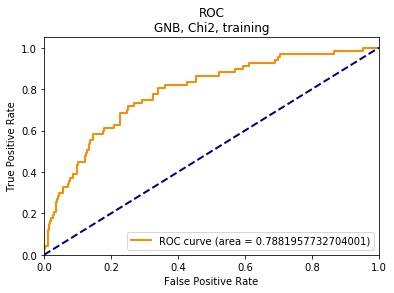

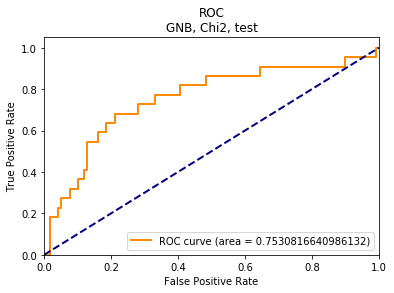

0.7530816640986132

In [86]:
print(nb_grid_search.best_params_)
print(classification_report(y_test, nb_grid_search.predict(X_test)))
plot_roc(nb_grid_search.predict_proba(X_train), y_train, notes="GNB, Chi2, training")
plot_roc(nb_grid_search.predict_proba(X_test), y_test, notes="GNB, Chi2, test")



# Pipeline 3 - RandomForest (just for fun)

In [87]:
from sklearn.ensemble import RandomForestClassifier

/Users/william/miniconda3/envs/vituity/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [88]:
ss = StandardScaler()    
etc = RandomForestClassifier(class_weight='balanced',max_depth=4)  # Without limiting the max depth, it overfits

pipe = Pipeline([
    ('reduce_dim', PCA()),
    ('clf', etc)
])

param_grid = {
        'reduce_dim': [PCA()],
        'reduce_dim__whiten': [True, False],
        'reduce_dim__n_components': sp_randint(4,29),
        'clf__n_estimators': sp_randint(5,25),
        'clf__bootstrap':[True,False],   
}
    

etc_grid_search = RandomizedSearchCV(pipe,
                                 scoring='roc_auc',
                                 param_distributions=param_grid,
                                 n_iter=1000,
                                 cv=5,
                                 verbose=0,
                                 n_jobs=-1)

etc_grid_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('reduce_dim', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=4, max_features='auto',
            max_leaf...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
          fit_params=None, iid=True, n_iter=1000, n_jobs=-1,
          param_distributions={'reduce_dim': [PCA(copy=True, iterated_power='auto', n_components=26, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)], 'reduce_dim__whiten': [True, False], 'reduce_dim__n_components': <scipy.stats._distn_infrastructure.rv_frozen object at 0x106b5d828>, 'clf__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x106b5d1d0>, 'clf__bootstrap': [True, False]},
          pre_di

{'clf__bootstrap': True, 'clf__n_estimators': 9, 'reduce_dim': PCA(copy=True, iterated_power='auto', n_components=26, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False), 'reduce_dim__n_components': 26, 'reduce_dim__whiten': False}
             precision    recall  f1-score   support

        0.0       0.87      0.90      0.88       118
        1.0       0.33      0.27      0.30        22

avg / total       0.78      0.80      0.79       140



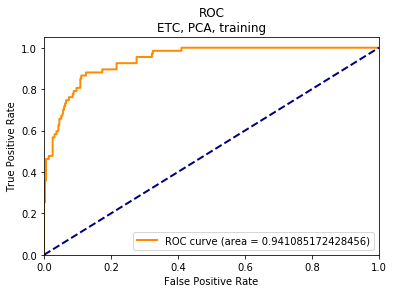

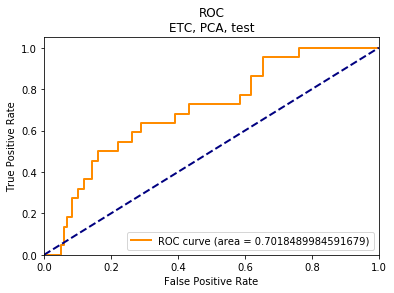

0.7018489984591679

In [89]:
print(etc_grid_search.best_params_)
print(classification_report(y_test, etc_grid_search.predict(X_test)))
plot_roc(etc_grid_search.predict_proba(X_train), y_train, notes="ETC, PCA, training")
plot_roc(etc_grid_search.predict_proba(X_test), y_test, notes="ETC, PCA, test")



# Calibration Curves

In [90]:
from sklearn.calibration import calibration_curve

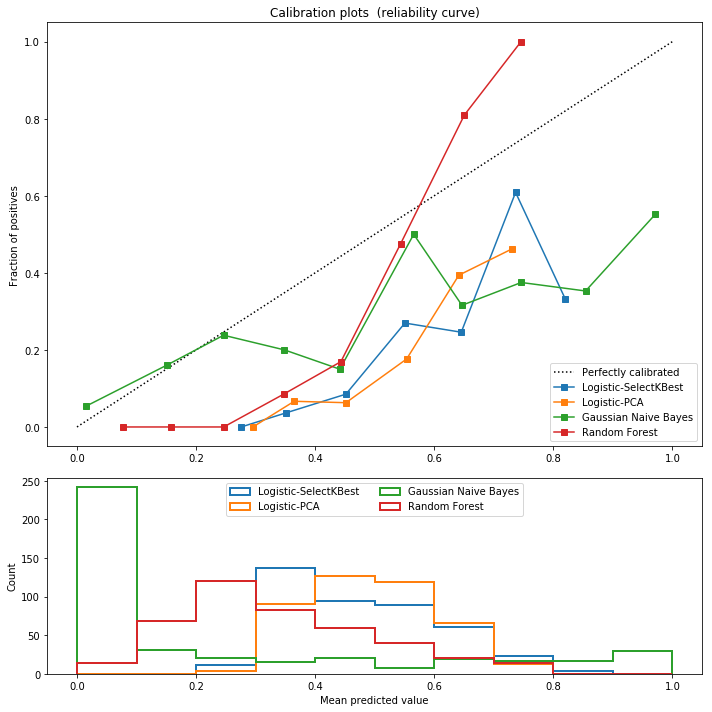

In [91]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(grid_search, 'Logistic-SelectKBest'),
                  (grid_search2, 'Logistic-PCA'),
                  (nb_grid_search, 'Gaussian Naive Bayes'),
                  (etc_grid_search, 'Random Forest')]:

    prob_pos = clf.predict_proba(X_train)[:, 1]

    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_train, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()
plt.show()

### Notes on calibration curve

It seems we don't have enough samples to reliably generate a calibration curve.

## Shap Model Explianer

In [92]:
X_hat_train = grid_search.best_estimator_.named_steps['scaler'].transform(
                    grid_search.best_estimator_.named_steps['reduce_dim'].transform(X_train)
                )

In [93]:
import shap

In [94]:
explainer = shap.LinearExplainer(grid_search.best_estimator_.steps[2][1], X_hat_train)
shap_values = explainer.shap_values(X_hat_train)

In [95]:
shap.initjs()

In [97]:
X_train.columns

Index(['chestpain', 'hxofCABG', 'mbp', 'hxofMI', 'gender_male',
       'hxofCig_non-smoker', 'hxofPTCA', 'age', 'dp', 'pctMphr',
       'hxofCig_heavy', 'restwma', 'ecg_equivocal', 'hxofDM', 'ecg_normal',
       'dobdose', 'hxofCig_moderate', 'dpmaxdo', 'basebp', 'maxhr', 'sbp',
       'baseEF', 'pkhr', 'hxofHT', 'ecg_MI', 'basedp', 'posSE', 'bhr',
       'gender_female'],
      dtype='object')

In [96]:
shap.force_plot(explainer.expected_value, shap_values, X_hat_train)
